In [1]:
import gdax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from math import ceil
from time import sleep

from backtest import Trader, DoubleTrader, historic_rates
from algorithms import SMA, EMA, MovingAverageAlgo

%matplotlib inline
public_client = gdax.PublicClient()

ImportError: cannot import name 'DoubleTrader'

From: 2018-02-18T14:33:04, To: 2018-02-18T20:23:04
From: 2018-02-18T08:43:04, To: 2018-02-18T14:33:04
From: 2018-02-18T02:53:04, To: 2018-02-18T08:43:04
From: 2018-02-17T21:03:04, To: 2018-02-18T02:53:04
From: 2018-02-17T15:13:04, To: 2018-02-17T21:03:04
From: 2018-02-17T09:23:04, To: 2018-02-17T15:13:04
From: 2018-02-17T03:33:04, To: 2018-02-17T09:23:04
From: 2018-02-16T21:43:04, To: 2018-02-17T03:33:04
From: 2018-02-16T15:53:04, To: 2018-02-16T21:43:04
From: 2018-02-16T10:03:04, To: 2018-02-16T15:53:04
From: 2018-02-16T04:13:04, To: 2018-02-16T10:03:04
From: 2018-02-15T22:23:04, To: 2018-02-16T04:13:04
From: 2018-02-15T16:33:04, To: 2018-02-15T22:23:04
From: 2018-02-15T10:43:04, To: 2018-02-15T16:33:04
From: 2018-02-15T04:53:04, To: 2018-02-15T10:43:04
From: 2018-02-14T23:03:04, To: 2018-02-15T04:53:04
From: 2018-02-14T17:13:04, To: 2018-02-14T23:03:04
From: 2018-02-14T11:23:04, To: 2018-02-14T17:13:04
From: 2018-02-14T05:33:04, To: 2018-02-14T11:23:04
From: 2018-02-13T23:43:04, To: 

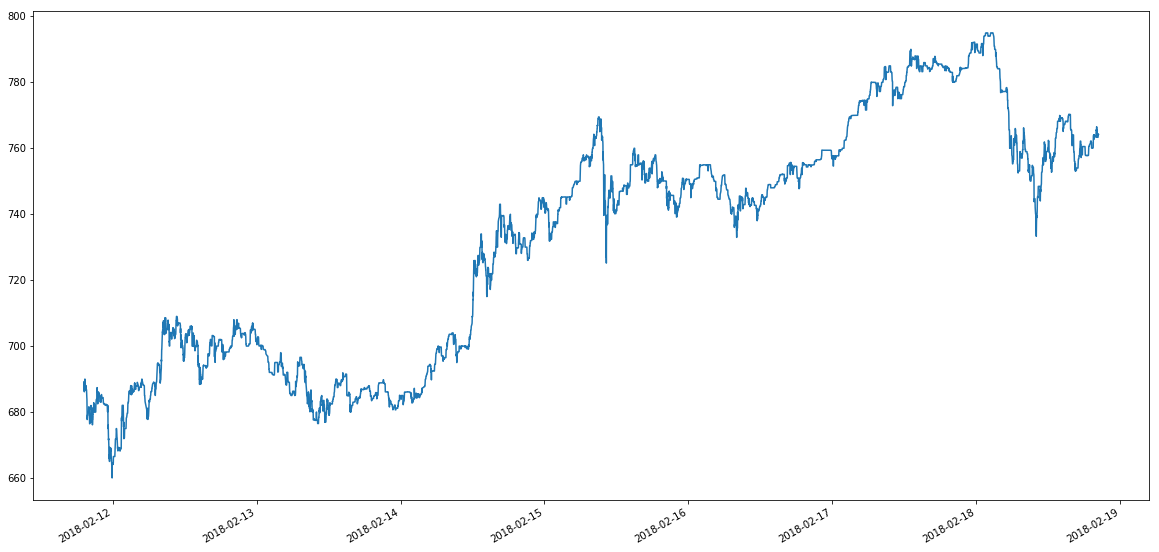

In [3]:
rates = historic_rates('ETH-EUR', 10000, granularity=60)
prices = [x[4] for x in rates]
while 'a' in prices: prices.remove('a')
times = [x[0] for x in rates]
while 'm' in times: times.remove('m')

prices.reverse()
times.reverse()

print(len(prices))

times_s = pd.Series(times).astype("datetime64[s]")
time_price = pd.Series(prices, times_s)

time_price.plot(figsize=(20,10))
print(prices[-1]/prices[0] * 100)
print(prices[:10])

Backtest Begins Here, loop over combinations of slow and fast Moving average window and calculate profit


In [4]:
def backtest(slow, fast, look_back, prices):
    assert(len(prices) >= slow + look_back)
    slow_avg = SMA(slow)
    fast_avg = SMA(fast)

    for price in prices[-(slow + look_back):-look_back]:
        slow_avg.tick(price)

    for price in prices[-(fast + look_back):-look_back]:
        fast_avg.tick(price)

    algo = MovingAverageAlgo(slow=slow_avg, 
                             fast=fast_avg,   
                             buy_cutoff=0.0,          
                             sell_cutoff=0.0)
    trader = Trader(algo, 
                    fee=0.0, 
                    trade_prob=1.0,
                    verbose=False)
    final = 0
    stance = False
    for price in prices[-look_back:]:
        final, stance = trader.tick(price)
    return final, stance, trader.num_trades
    
    

In [18]:
def backtest_algo(look_back, top_win, prices, verbose=False):
    potential = []
    votes = []
    num_voters = 3

    for slow in range (2, top_win, 1):
        for fast in range(1, slow, 1):
            final, stance, num_trades = backtest(slow=slow, fast=fast, look_back=look_back, prices=prices)
            potential.append((fast, slow, final, num_trades, stance))
    potential.sort(key=lambda tup: tup[2], reverse=True)
    for sims in potential[:3]:
        if verbose: print("{} - {}: {}x [{}] ({})".format(*sims))
        votes.append(sims[4])
    return (sum(votes) / num_voters) > 0.5


In [19]:
class AdaptiveAlgo:
    def __init__(self, look_back, top_win, prices, verbose=False):
        self.look_back = look_back
        self.top_win = top_win
        self.prices = np.array(prices)
        self.verbose=verbose
        
    def tick(self, price):
        self.prices = np.roll(self.prices, -1)
        self.prices[-1] = price
        return backtest_algo(look_back=self.look_back, 
                             top_win=self.top_win, 
                             prices=self.prices, 
                             verbose=self.verbose)
        

In [20]:
print(prices[-50]/prices[-1])

1.020748145629591


In [21]:
top_win = 50
far_back = 200

print(prices[far_back]/prices[-1])

ada_algo = AdaptiveAlgo(look_back=top_win, 
                        top_win=top_win, 
                        prices=prices[far_back-(2*top_win):far_back], 
                        verbose=False)
trader = Trader(ada_algo, verbose=False)
for price in prices[far_back:-1]:
    print("Price: {}, Value: {}, Stance: {}".format(price, *trader.tick(price)))

1.2803432262913486
Price: 11447.6, Value: 100.0, Stance: False
Price: 10995.91, Value: 100.0, Stance: False
Price: 11467.12, Value: 100.0, Stance: False
Price: 11900, Value: 100.0, Stance: False
Price: 11898.85, Value: 100.0, Stance: False
Price: 12900, Value: 100.0, Stance: False
Price: 12785.68, Value: 100.0, Stance: False
Price: 13549.99, Value: 100.0, Stance: False
Price: 12703.79, Value: 100.0, Stance: False
Price: 12587.45, Value: 100.0, Stance: False
Price: 12299.96, Value: 100.0, Stance: False
Price: 12607.07, Value: 100.0, Stance: False
Price: 13000, Value: 100.0, Stance: True
Price: 12999.54, Value: 99.99646153846155, Stance: True
Price: 12755.65, Value: 98.12038461538461, Stance: True
Price: 12729.46, Value: 97.91892307692306, Stance: True
Price: 13063.63, Value: 100.48946153846153, Stance: True
Price: 13220.05, Value: 101.6926923076923, Stance: False
Price: 13226.25, Value: 101.6926923076923, Stance: False
Price: 13486.5, Value: 101.6926923076923, Stance: False
Price: 13893

KeyboardInterrupt: 

In [6]:
potential = []
from_v = 512

votes = []
num_voters = 3

for slow in range (2, 200, 1):
    for fast in np.arange(1, slow, 1):
        final, stance, num_trades = backtest(slow=slow, fast=fast, look_back=from_v, prices=prices)
        buy_hold = prices[-1]/prices[from_v] * 100
        potential.append((fast, slow, final/buy_hold, final, num_trades, buy_hold, stance))
potential.sort(key=lambda tup: tup[3], reverse=True)
for sims in potential[:3]:
    print("{} - {}: {}x [{}] ({}) [{}] {}".format(*sims))
    votes.append(sims[6])
print(sum(votes))


5 - 7: 0.961143741746995x [106.49784817753677] (63) [110.80324778889373] True
1 - 3: 0.9603915024471262x [106.41449761999687] (157) [110.80324778889373] True
5 - 8: 0.9587278033112561x [106.23015435239887] (47) [110.80324778889373] True
3


In [ ]:
# Peform a single run with the optimal parameters from the previous cell
print("Single Run")

slow_win = potential[0][1]
fast_win = potential[0][0]

slow_avg = EMA(slow_win)
fast_avg = SMA(fast_win)

for price in prices[-(slow_win + from_v):-from_v]:
    slow_avg.tick(price)
    
for price in prices[-(fast_win + from_v):-from_v]:
    fast_avg.tick(price)


algo = MovingAverageAlgo(slow=slow_avg, 
                         fast=fast_avg,   
                         buy_cutoff=0,          
                         sell_cutoff=0)
trader = Trader(algo, verbose=True)
for price in prices[-from_v:]:
    trader.tick(price)

In [31]:
# Grid search for optimal offsets
potential = []
for b_offset in np.arange(-0.0028, -0.0026, 0.00001):
    for s_offset in np.arange(-0.0026, -0.0024, 0.00001):
        #print("{}, {}".format(fast, slow))
        b_offset = round(b_offset, 5)
        s_offset = round(s_offset, 5)

        slow_avg = EMA(23)
        fast_avg = SMA(16)
        algo = MovingAverageAlgo(slow=slow_avg, 
                                 fast=fast_avg,   
                                 buy_cutoff=b_offset,          
                                 sell_cutoff=s_offset)
        trader = Trader(algo, 
                        fee=0.0, 
                        trade_prob=0.9)
        final = 0
        for price in prices:
            final = trader.tick(price)
        buy_hold = prices[-1]/prices[slow] * 100
        if final >= prices[-1]/prices[slow] * 100:
        #if final > 100.0:
            potential.append((final, b_offset, s_offset))
            print("{} - {}: {}x [{}] ({}) [{}]".format(b_offset, s_offset, final/buy_hold, final, trader.num_trades, buy_hold))
potential.sort(key=lambda tup: tup[0], reverse=True)
print(potential)


-0.0028 - -0.0026: 1.9519335267066364x [146.0535740095761] (94) [74.82507575757576]
-0.0028 - -0.00259: 1.7998420247703792x [134.67331585511218] (92) [74.82507575757576]
-0.0028 - -0.00258: 1.8487329624213977x [138.33158396870854] (92) [74.82507575757576]
-0.0028 - -0.00257: 1.8299192414196785x [136.923845869473] (92) [74.82507575757576]
-0.0028 - -0.00256: 1.8210458515188432x [136.2598937979165] (92) [74.82507575757576]
-0.0028 - -0.00255: 1.794453148666999x [134.27009279242856] (90) [74.82507575757576]
-0.0028 - -0.00254: 1.8269216707751252x [136.69955241890563] (92) [74.82507575757576]
-0.0028 - -0.00253: 1.7768413400309702x [132.95228787700978] (90) [74.82507575757576]
-0.0028 - -0.00252: 1.8449009232724123x [138.04485134907972] (90) [74.82507575757576]
-0.0028 - -0.00251: 1.849911828521842x [138.41979271398233] (90) [74.82507575757576]
-0.0028 - -0.0025: 1.7172373338443103x [128.49241359863794] (94) [74.82507575757576]
-0.0028 - -0.00249: 1.7982286871294133x [134.55259774390436] (

In [32]:
slow_vals = []
fast_vals = []
signals = []

slow_v = 7
fast_v = 4

slow = EMA(slow_v)
fast = SMA(fast_v)
slow_avg = EMA(slow_v)
fast_avg = SMA(fast_v)
algo = MovingAverageAlgo(slow=slow_avg, 
                         fast=fast_avg,   
                         buy_cutoff=0,          
                         sell_cutoff=0)
for price in prices:
    slow_vals.append(slow.tick(price))
    fast_vals.append(fast.tick(price))
    signals.append(1 if algo.tick(price) else 0)


[10578.16, 10671.37, 10633.76, 10585.6, 10313, 10402.33, 10458.55, 10370.51, 10251, 10160.93, 10112.01, 9876.91]
[1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[10573.033311262943, 10607.798810312039, 10623.70790378249, 10613.848572233572, 10527.182292033529, 10484.620988941326, 10474.934887652322, 10440.831720081707, 10377.184644643236, 10304.911516517575, 10238.447401563712, 10131.268502500528]
[10606.600000000042, 10621.837500000043, 10606.027500000044, 10617.222500000044, 10550.932500000043, 10483.672500000042, 10439.870000000043, 10386.097500000044, 10370.597500000044, 10310.247500000043, 10223.612500000043, 10100.212500000041]


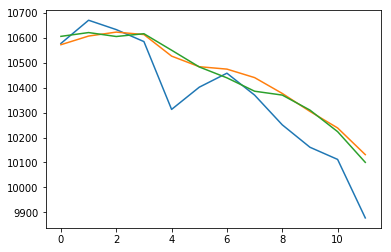

In [29]:
print(prices[-from_v:])
print(signals[-from_v:])
print(slow_vals[-from_v:])
print(fast_vals[-from_v:])
plt.plot(prices[-from_v:])
plt.plot(slow_vals[-from_v:])
plt.plot(fast_vals[-from_v:])

In [21]:
a = [1,2,3,4]
a[-3:-2]

[2]

0 - Price: 10578.16, Stance: Out, Decision: Buy, Value: 100.0
1 - Price: 10671.37, Stance: In, Decision: Buy, Delta: 0.8811551347304346, Value: 100.88115513473043
2 - Price: 10633.76, Stance: In, Decision: Buy, Delta: -0.35554387530535164, Value: 100.52561125942508
3 - Price: 10585.6, Stance: In, Decision: Buy, Delta: -0.4552776664372618, Value: 100.07033359298781
4 - Price: 10313, Stance: In, Decision: Buy, Delta: -2.577007721569728, Value: 97.49332587141808
5 - Price: 10402.33, Stance: In, Decision: Buy, Delta: 0.8444757878496819, Value: 98.33780165926777
6 - Price: 10458.55, Stance: In, Decision: Buy, Delta: 0.5314723921740581, Value: 98.86927405144182
7 - Price: 10370.51, Stance: In, Decision: Buy, Delta: -0.8322808503558183, Value: 98.036993201086
8 - Price: 10251, Stance: In, Decision: Buy, Delta: -1.1297806045663916, Value: 96.90721259651961
9 - Price: 10160.93, Stance: In, Decision: Buy, Delta: -0.8514713333887908, Value: 96.05574126313083
10 - Price: 10112.01, Stance: In, Deci

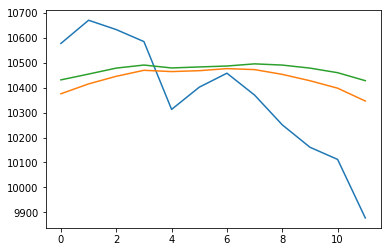

In [18]:
plt.plot(prices[-from_v:])
plt.plot(slow_vals[-from_v:])
plt.plot(fast_vals[-from_v:])

from_v = 12
slow_win = 23
fast_win = 16

slow_avg = EMA(slow_win)
fast_avg = SMA(fast_win)

for price in prices[-(slow_win + from_v):-from_v]:
    slow_avg.tick(price)
    
for price in prices[-(fast_win + from_v):-from_v]:
    fast_avg.tick(price)


algo = MovingAverageAlgo(slow=slow_avg, 
                         fast=fast_avg,   
                         buy_cutoff=0,          
                         sell_cutoff=0)
trader = Trader(algo)
for price in prices[-from_v:]:
    trader.tick(price)


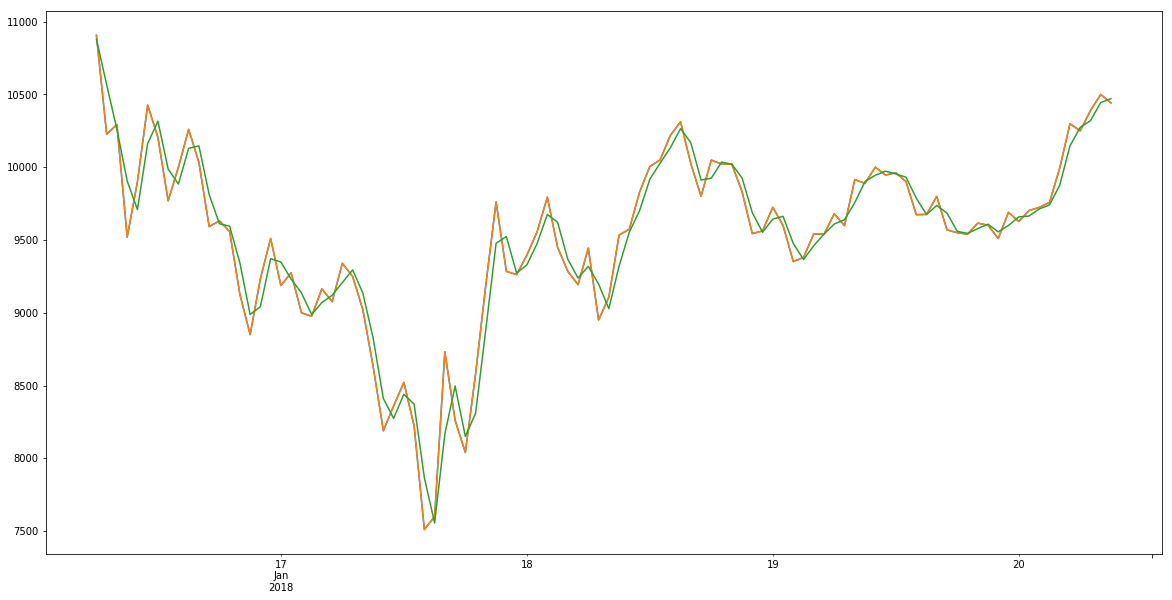

In [43]:
fast = 1
slow = 2

mvag_fast = time_price.rolling(window=fast,center=False).mean()
mvag_slow = time_price.rolling(window=slow,center=False).mean()

time_price.tail(100).plot(figsize=(20,10))
mvag_fast.tail(100).plot(figsize=(20,10))
mvag_slow.tail(100).plot(figsize=(20,10))

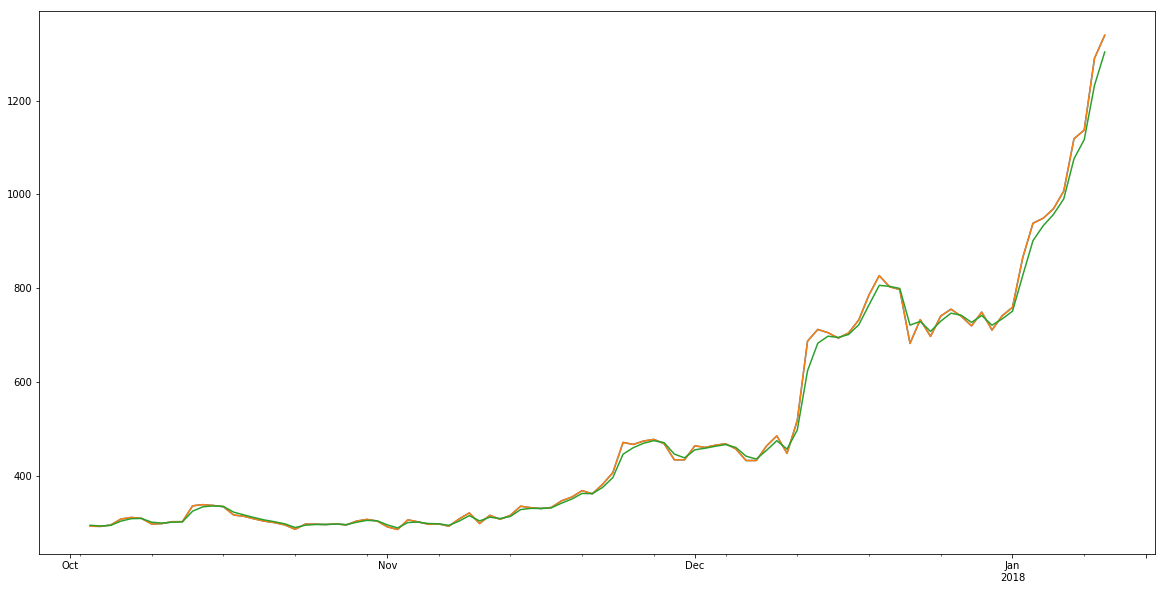

In [243]:
emvag_fast = time_price.ewm(span=fast, adjust=False).mean()
emvag_slow = time_price.ewm(span=slow, adjust=False).mean()

time_price.tail(100).plot(figsize=(20,10))
emvag_fast.tail(100).plot(figsize=(20,10))
emvag_slow.tail(100).plot(figsize=(20,10))

In [189]:
window = 200
e = EMA(window)
s = SMA(window * 2)
ema_test = []
sma_test = []
for price in prices:
    ema_test.append(e.tick(price))
    sma_test.append(s.tick(price))

ema_test = ema_test[window-1:]
sma_test = sma_test[(window * 2)-1:]

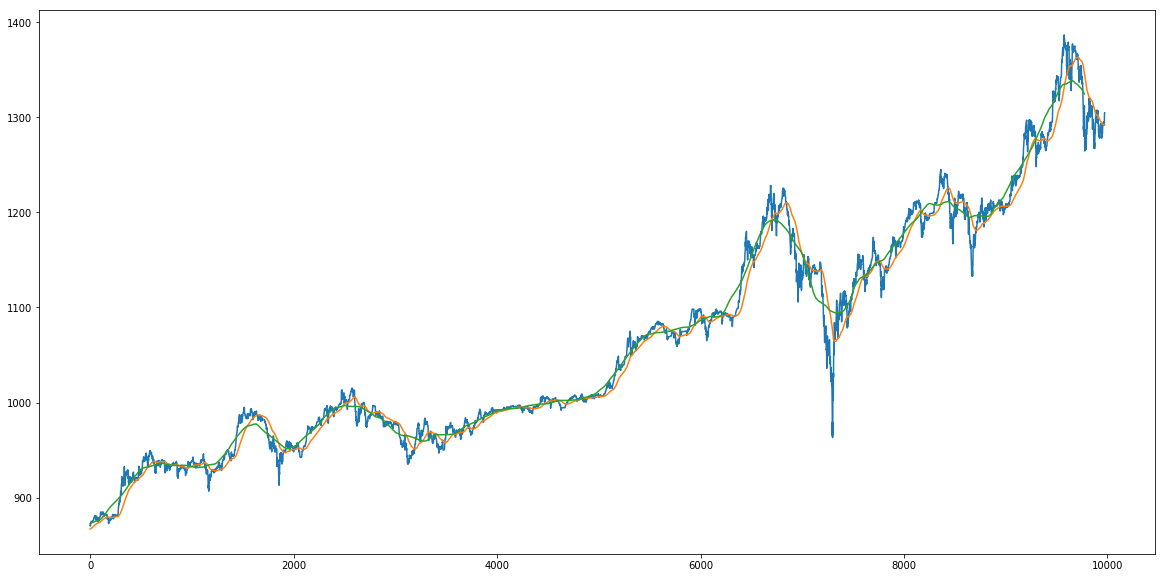

In [190]:
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(prices[window:])
plt.plot(ema_test)
plt.plot(sma_test)